In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import itertools

import torch
from torch import nn

import youtokentome as yttm

from utils.base import get_params_number, init_random_seed, train_loop_GAN
from utils.poetry import *
from utils.transformer_tools import *

init_random_seed(1702)

In [2]:
horus = load_chunks("./datasets/DarkTower/DT14_red.txt", chunk_size=300)

ALL_LEN = len(horus)
print(ALL_LEN)
len_for_steps = int(ALL_LEN / 3)
horus_for_GAN = horus[len_for_steps * 2:]
horus = horus[:len_for_steps * 2]
print(len(horus))
print(len(horus_for_GAN))

22507
15004
7503


In [3]:
for_mauve_test = horus_for_GAN[len(horus_for_GAN)-100:]
horus_for_GAN = horus_for_GAN[:len(horus_for_GAN)-100]

print(len(horus_for_GAN))
print(len(for_mauve_test))

7403
100


In [4]:
BPE_MODEL_FILENAME = './models/tokens/dt_bpe_2000.yttm'

tokenizer = yttm.BPE(BPE_MODEL_FILENAME)
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ e t a o n h i s d r l u w g c m f y . b , p k v T I E H “ ’ ” A S - " R O ? ' N W B D J Y M C L x z ! j G F … ; U P q : K ) ( V ­ — 1 – 2 3 4 9 5 7 0 Q 6 8 X Z / ‘ $ * » ^ \ # + « ~ _ ] [ & ▁t he ▁a in ▁s ▁the ▁w ▁o ▁h nd ed ▁b er ou ing re ▁f it ▁c at is ▁d ▁l ▁m as en ▁th ▁and ▁to ▁of ▁he ll an ▁g ar ad es on or ▁p ▁in ▁n ▁T ▁was id ow ▁be om ut ▁it gh ld ▁y ot ▁on le ke ▁e ▁“ ac ▁his ▁I im ly ▁st ▁H us and ic ▁r ▁had ▁you oo un ▁The ght ie et ay ▁that ▁wh ve dd al ▁S ver ▁sa os ▁as ▁E ir ol ▁re ▁He ith ▁A ould ▁at ’s ain ight ▁with ▁R ur ent ked ddie ▁Eddie el ▁him e. her ▁k ake am ▁sh ▁for ▁B ▁u ▁J ▁li ▁but e, ▁an ter all ack ▁" ▁said ▁ha ▁se ▁her oland ▁not ▁Roland ling s. pp ill ch ▁fr st ▁loo ▁do if ion s, ▁gun ▁W ▁Jake ard .” ▁kn ▁M ome ore ▁up ’t ▁like ▁she ust il ed. ▁whe ere ▁O ▁C ound ▁al th ▁out ell ▁guns ▁j ▁tr ant ▁from ind ▁all ro ▁one ck ▁were linger ▁this ▁they ▁gunslinger um em ▁been ▁them ▁would ▁have ▁ne ▁bl ▁le ▁ag to ap ?” hed ▁D ▁su ood

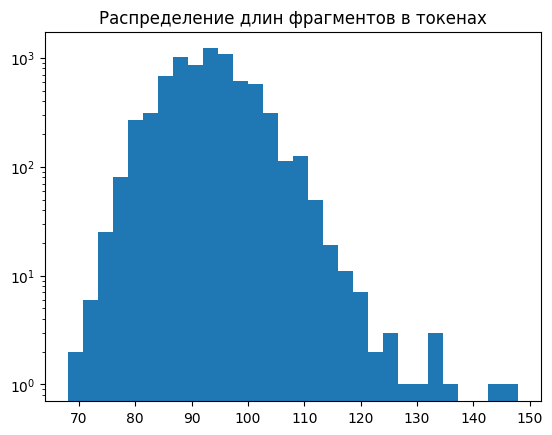

In [5]:
token_ids = tokenizer.encode(horus_for_GAN, bos=True, eos=True)

plt.hist([len(sent) for sent in token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log')

In [6]:
start_length = 20
end_length = 70

all_dataset = Dataset_for_GAN(token_ids, start_len=start_length, end_len=end_length)

In [7]:
check = all_dataset[2036]

print(check[0])
print(check[1])
print(tokenizer.decode(check[0].tolist()))
print(tokenizer.decode(check[1].tolist()))

[ 152   25  426  188  171  371  668  163 1101  251  530 1101  366  127
  233  406 1468 1238  136 1224]
[ 112  105  450  110   13 1330  198  253    8  137 1421 1089  105 1010
  538  137 1268  638  785  384  104  287 1127  489 1324 1779  127  324
  513  210  326  561  147  110  140  105  683  125  114  311 1303  155
    6  576  162  129  105 1585  258  102  355  124  327  373  132  177
   23  668  484 1786  188  797  188  507  370  170  843  776  539  143]
['y, just as you said. Only wait.” They waited, and not twenty minutes lat']
['er the Peddler’s Moon rose above the horizon-a perfect summer moon, huge and orange. It loomed in the darkening violet swim of the sky like a crashing planet. On its face, as clear as anyone had ever seen it, was']


In [8]:
D_model = LSTM_Discriminator(100, 256, tokenizer.vocab_size())
print('Количество параметров дискриминатора', get_params_number(D_model))

G_model = Language_Model(
    vocab_size = tokenizer.vocab_size(),
    embedding_size = 512,
    backbone = Transformer_Encoder(
        nn.TransformerEncoderLayer(
            d_model = 512,
            nhead = 16,
            dim_feedforward = 1024,
            dropout = 0.3
        ),
        num_layers=5
    ),
    emb_dropout = 0.2
)
print('Количество параметров генератора', get_params_number(G_model))

Количество параметров дискриминатора 655301
Количество параметров генератора 12563920


In [9]:
optimizer_SD_G = torch.load('./models/Lord/DT/1/Lord_opt.pth')
G_model.load_state_dict(torch.load('./models/Lord/DT/1/Lord.pth'))

<All keys matched successfully>

In [11]:
batch_size = 64

model_D, model_G, optimizer_D, optimizer_G, loss_history_D, loss_history_G = train_loop_GAN(
    D_model,
    G_model,
    all_dataset,
    lm_b_cross_entropy,
    lr_D=1e-2,
    lr_G=1e-2,
    epoch_n=150,
    batch_size=batch_size,
    device='cuda',
    # early_optimizer_SD_D=optimizer_SD_D,
    early_optimizer_SD_G=optimizer_SD_G,
    tokenizer=tokenizer,
    need_to_gen=True,
    end_chunk=end_length,
    phrase="Today we are going"
)

Эпоха 0


116it [02:11,  1.13s/it]


Эпоха прошла за 131.63 секунд
Средняя функция потерь для дискриминатора = 0.5576611174077823
Средняя функция потерь для генератора = 2.9146295600923997
Today we are going on,” Blaine said. “THISTEN MNE ANTING T QUICKY TO HOWN GUNDLIES RIDDLES AND YOU K
Следующая эпоха
Эпоха 1


116it [02:12,  1.14s/it]


Эпоха прошла за 132.07 секунд
Средняя функция потерь для дискриминатора = 0.3595854953445237
Средняя функция потерь для генератора = 3.8548585382001153
Today we are going?” Susannah asked. “Theymos. It’s in the aftermath of the river and it’s still tatter,” the Final Essay said. “THAT IS NOT RIG
Следующая эпоха
Эпоха 2


116it [02:11,  1.14s/it]


Эпоха прошла за 131.86 секунд
Средняя функция потерь для дискриминатора = 0.273517402081654
Средняя функция потерь для генератора = 4.527357397408321
Today we are going much long since you had killed?” Susannah asked in the dry straps of harness, and Engineer Bob in the word Parker. “Thank you. TWOIN
Следующая эпоха
Эпоха 3


116it [02:11,  1.13s/it]


Эпоха прошла за 131.31 секунд
Средняя функция потерь для дискриминатора = 0.21610567827933821
Средняя функция потерь для генератора = 5.269818010001347
Today we are going?” “YOU I SAIDD YOU WITH YOU INTERESTY ME ANOTHER.” There is a pause, and no one of those museum
Следующая эпоха
Эпоха 4


116it [02:11,  1.13s/it]


Эпоха прошла за 131.57 секунд
Средняя функция потерь для дискриминатора = 0.17978157135176248
Средняя функция потерь для генератора = 5.792122890209329
Today we are going in a bottle of Katz Dra Delevan's Dr. "What you calling him?" "Good my brother asked. "Only shit!" " 'Cim
Следующая эпоха
Эпоха 5


116it [02:11,  1.13s/it]


Эпоха прошла за 131.09 секунд
Средняя функция потерь для дискриминатора = 0.19053234079660014
Средняя функция потерь для генератора = 5.8707191944122314
Today we are going?” She laughed at him. “COME ONE YOURO MANNING. ROLAND OF GILEAD, BUT THE QUMEST NEW FR
Следующая эпоха
Эпоха 6


116it [02:11,  1.13s/it]


Эпоха прошла за 131.17 секунд
Средняя функция потерь для дискриминатора = 0.17337904854452815
Средняя функция потерь для генератора = 6.214724789405691
Today we are going to Ringtin from the Path of the Turtle, and by the Beam. Beam-hour tend on your goose alone, Mr. Bissette
Следующая эпоха
Эпоха 7


116it [02:11,  1.13s/it]


Эпоха прошла за 131.26 секунд
Средняя функция потерь для дискриминатора = 0.15916851776298777
Средняя функция потерь для генератора = 6.18911952396919
Today we are going in the PRAe.” Ster’s SMECHERS IN THE BARONY OF THE LUMEND 1-6 IN THE SHOUNDUS
Следующая эпоха
Эпоха 8


116it [02:11,  1.13s/it]


Эпоха прошла за 131.32 секунд
Средняя функция потерь для дискриминатора = 0.13524620363424564
Средняя функция потерь для генератора = 6.423249750301756
Today we are going cold taste so through the course-” “YES,” Blaine agreed, and sounded like the Mog of a harmonies hanging on in Tom and Engineer
Следующая эпоха
Эпоха 9


116it [02:11,  1.13s/it]


Эпоха прошла за 131.32 секунд
Средняя функция потерь для дискриминатора = 0.14706665511917452
Средняя функция потерь для генератора = 6.577110265863353
Today we are going on this-they?” Jake asked. “Then why Mr. Bissette was standing-outine in front of the Barony Coach. In the world, there’s anymore,
Следующая эпоха
Эпоха 10


116it [02:11,  1.13s/it]


Эпоха прошла за 131.16 секунд
Средняя функция потерь для дискриминатора = 0.1375601394423123
Средняя функция потерь для генератора = 6.654337504814411
Today we are going?” Susannah asked. “What do you think-” “This is your purpose.” “DOES,” Blaine went to listening Susannah to the Cradle of the voice. “But I-” “R
Следующая эпоха
Эпоха 11


116it [02:11,  1.13s/it]


Эпоха прошла за 131.5 секунд
Средняя функция потерь для дискриминатора = 0.14222643065169968
Средняя функция потерь для генератора = 6.689780111970572
Today we are going wrong. Who are you?" "Okay?” Eddie asked. "Or. What is the Tower." uttersaneat Dadio ignored him. The gunslinger is able to read some
Следующая эпоха
Эпоха 12


116it [02:11,  1.13s/it]


Эпоха прошла за 131.56 секунд
Средняя функция потерь для дискриминатора = 0.13498268876995506
Средняя функция потерь для генератора = 6.764889540343449
Today we are going in the same place of my place.” The gunslinger nodded sigh to his hold up to his head and posed for the Dark Tower and raised his head on the handrail. The man
Следующая эпоха
Эпоха 13


116it [02:11,  1.13s/it]


Эпоха прошла за 131.31 секунд
Средняя функция потерь для дискриминатора = 0.137795887052499
Средняя функция потерь для генератора = 6.556824334736528
Today we are going to find. Topeka, Mr. From 199370s. Shawn, Jake supposed, very awake a little draw closer.“Yougre you making the
Следующая эпоха
Эпоха 14


116it [02:11,  1.14s/it]


Эпоха прошла за 131.71 секунд
Средняя функция потерь для дискриминатора = 0.15707652237073616
Средняя функция потерь для генератора = 6.499055336261618
Today we are going to stand at this same time. Quakes, I became truick. I think it’s true." He helped Susannah as sudden as the story astin of the ex
Следующая эпоха
Эпоха 15


116it [02:11,  1.13s/it]


Эпоха прошла за 131.34 секунд
Средняя функция потерь для дискриминатора = 0.18151280524787203
Средняя функция потерь для генератора = 6.167656051701512
Today we are going?” Jeeves and Susannah asked. Her voice was softened. “THEE IS NOT, AND GUSANNAHINGER,” Blaine said. “TOES A LIT
Следующая эпоха
Эпоха 16


116it [02:11,  1.13s/it]


Эпоха прошла за 131.21 секунд
Средняя функция потерь для дискриминатора = 0.1651274185178095
Средняя функция потерь для генератора = 6.0228108743141435
Today we are going to give in this town-that,” said Aunt Talitha said dismissively. “it down the mirrors.” Eddie felt a feeling discover on a sense of
Следующая эпоха
Эпоха 17


116it [02:11,  1.13s/it]


Эпоха прошла за 131.19 секунд
Средняя функция потерь для дискриминатора = 0.159104621776476
Средняя функция потерь для генератора = 6.573330143402362
Today we are going?” Eddie asked. “ “Crrawed-” “It’s coming from the same you,” Susannah murmured. Her eyes gaze shiftedly at the corners of her mouth. “A
Следующая эпоха
Эпоха 18


116it [02:11,  1.13s/it]


Эпоха прошла за 131.21 секунд
Средняя функция потерь для дискриминатора = 0.16527414003965155
Средняя функция потерь для генератора = 6.138829798533998
Today we are going?” Susannah, and her voice was still so deeply that Eddie thought it must have heard it. “Do you agree?” “I think I’m sorry to ask him.” “If Blaine the M
Следующая эпоха
Эпоха 19


116it [02:11,  1.14s/it]


Эпоха прошла за 131.73 секунд
Средняя функция потерь для дискриминатора = 0.1538563166455976
Средняя функция потерь для генератора = 5.940147424566335
Today we are going wrong?” Eddie asked. “Criped with you were chained. “Yet.” He tiped his hips seemed to be over his shoulder to the hips of his pack
Следующая эпоха
Эпоха 20


116it [02:11,  1.13s/it]


Эпоха прошла за 131.29 секунд
Средняя функция потерь для дискриминатора = 0.18306565079195747
Средняя функция потерь для генератора = 5.888167040101413
Today we are going over here?” The boy in his lawy as well as he talked: “Of course it was, he card off. “Uh-huh,” the woman saysuing
Следующая эпоха
Эпоха 21


116it [02:11,  1.14s/it]


Эпоха прошла за 131.72 секунд
Средняя функция потерь для дискриминатора = 0.17880617634489618
Средняя функция потерь для генератора = 5.855720926975382
Today we are going?" "Yeah," Eddie said, nodding furiused. "I keep thinking pureing her. "Suck shit out of her, all." "That's this?" "Yes." "Do you mean I
Следующая эпоха
Эпоха 22


116it [02:11,  1.13s/it]


Эпоха прошла за 131.54 секунд
Средняя функция потерь для дискриминатора = 0.18198314505019064
Средняя функция потерь для генератора = 6.009564901220387
Today we are going to hell in first hell: DO YOU TRAVE MY RIDDLES?” “THESE OF FROM THE NEXT YOUR RIDDLE
Следующая эпоха
Эпоха 23


116it [02:11,  1.13s/it]


Эпоха прошла за 131.26 секунд
Средняя функция потерь для дискриминатора = 0.17316346194852014
Средняя функция потерь для генератора = 5.747703766000682
Today we are going to be at least three thousand years, suggar. My version of ‘Sluther Stephen King electricia… Traclem
Следующая эпоха
Эпоха 24


116it [02:11,  1.13s/it]


Эпоха прошла за 131.13 секунд
Средняя функция потерь для дискриминатора = 0.16906193415794907
Средняя функция потерь для генератора = 5.953948415558914
Today we are going wrong?” Jake asked. “Oy!” Jake said wonderfullied, then turned his head.“Don’t. I think he’s talking to me, but he’s supposed to talk about how badly such a
Следующая эпоха
Эпоха 25


116it [02:11,  1.14s/it]


Эпоха прошла за 131.77 секунд
Средняя функция потерь для дискриминатора = 0.17415859319012741
Средняя функция потерь для генератора = 5.763312265790742
Today we are going?” Susannah asked. “What is it?” Eddie appeared in the wooden eye. It was stirredible that if he had been“You all roads well metals,” Henry said. “THAT
Следующая эпоха
Эпоха 26


116it [02:10,  1.13s/it]


Эпоха прошла за 130.62 секунд
Средняя функция потерь для дискриминатора = 0.21348516052139216
Средняя функция потерь для генератора = 5.8300867327328385
Today we are going in 198: WHN KA-TETHING YOU RUDDE, ROLAND OF GILES. LITT, YOU ROLAND OF GI
Следующая эпоха
Эпоха 27


116it [02:10,  1.13s/it]


Эпоха прошла за 130.78 секунд
Средняя функция потерь для дискриминатора = 0.19478689031354313
Средняя функция потерь для генератора = 5.793733058304622
Today we are going cold turb of shit, and he ain't ’gadget’it’ but ’gad ’ge, he’” Runt. Plemit’ S
Следующая эпоха
Эпоха 28


116it [02:10,  1.13s/it]


Эпоха прошла за 130.8 секунд
Средняя функция потерь для дискриминатора = 0.1871342313925511
Средняя функция потерь для генератора = 5.557565993276135
Today we are going at the Portal Tal Topeka, KNOW-Day”). “We’llop trip it off. Once Mrs. Ron 40 From M
Следующая эпоха
Эпоха 29


116it [02:11,  1.13s/it]


Эпоха прошла за 131.12 секунд
Средняя функция потерь для дискриминатора = 0.2108851931989193
Средняя функция потерь для генератора = 5.675264083105942
Today we are going in our world,” Susannah said. “THES, SUSANNAHINGER, ANALTING OF NEW YORK ARE.” There was a kind of
Следующая эпоха
Эпоха 30


116it [02:10,  1.13s/it]


Эпоха прошла за 130.72 секунд
Средняя функция потерь для дискриминатора = 0.22161676513095355
Средняя функция потерь для генератора = 5.436965231237741
Today we are going to volume is Down! SHUT, Must  REALT YOUR LISTY A RUDLE, SON, BUT THEIR
Следующая эпоха
Эпоха 31


116it [02:11,  1.13s/it]


Эпоха прошла за 131.18 секунд
Средняя функция потерь для дискриминатора = 0.21199892499837383
Средняя функция потерь для генератора = 5.498480188435521
Today we are going to southeast, Eddie thought. A bad southeast. And the demon of Blaine is the Prisoner. “I WOULD HEREARGHT TH
Следующая эпоха
Эпоха 32


116it [02:10,  1.13s/it]


Эпоха прошла за 130.86 секунд
Средняя функция потерь для дискриминатора = 0.21677984554192115
Средняя функция потерь для генератора = 5.19719594922559
Today we are going?” Onward course occuring the rear of the holes in the fire. It was almost as if you were blot regard to all off the Tick-Tock Man’s scailing
Следующая эпоха
Эпоха 33


116it [02:10,  1.13s/it]


Эпоха прошла за 130.68 секунд
Средняя функция потерь для дискриминатора = 0.2341464429066099
Средняя функция потерь для генератора = 5.043630312229025
Today we are going on here?" McDonald head. "Let's off?" Tricks later," Katz said mildly, " "She answered off. Let off
Следующая эпоха
Эпоха 34


116it [02:11,  1.13s/it]


Эпоха прошла за 131.24 секунд
Средняя функция потерь для дискриминатора = 0.2358991619970264
Средняя функция потерь для генератора = 4.7691367864608765
Today we are going?” Eddie asked. “Not a little more than I than that gotton we went. That’s the story of the way an old dayland.” “Someo,” Eddie said. “I want
Следующая эпоха
Эпоха 35


116it [02:10,  1.13s/it]


Эпоха прошла за 130.81 секунд
Средняя функция потерь для дискриминатора = 0.221657851004395
Средняя функция потерь для генератора = 5.135821132824339
Today we are going to raise until earlandis by Christ,” Que voice. Susannah said. “Christ on fire. We’re a little trumper, you!” Eddie explosion shook
Следующая эпоха
Эпоха 36


116it [02:11,  1.13s/it]


Эпоха прошла за 131.04 секунд
Средняя функция потерь для дискриминатора = 0.21641955322361198
Средняя функция потерь для генератора = 5.096030202405206
Today we are going much popeka, and so I want to see it.” “Cy,” Tick-Tock said. “Bring me my gentlem.” Oy pound clevertedly onto the side of the
Следующая эпоха
Эпоха 37


116it [02:11,  1.13s/it]


Эпоха прошла за 131.18 секунд
Средняя функция потерь для дискриминатора = 0.21788606561463456
Средняя функция потерь для генератора = 5.328884449498407
Today we are going in the Path of the Turtle Bath of Pathbin” and “say ’gglow?” “I don’t know how he’s going to tell,” the
Следующая эпоха
Эпоха 38


116it [02:10,  1.13s/it]


Эпоха прошла за 130.61 секунд
Средняя функция потерь для дискриминатора = 0.2046330944345943
Средняя функция потерь для генератора = 5.505434254120136
Today we are going?” Susannah asked. “Yeah, Go on!” Eddie cried. “Will your palportal of us, Blaine,” Jake of Barony Coach an engineer (
Следующая эпоха
Эпоха 39


116it [02:11,  1.13s/it]


Эпоха прошла за 131.11 секунд
Средняя функция потерь для дискриминатора = 0.22415474664162974
Средняя функция потерь для генератора = 5.288922355092805
Today we are going?” Susannah asked. “Yeah, sure there’s always the answer. Not really nothing.” “Of course it has been used-” “HOW HAVE FOUNSY BOOK ALL
Следующая эпоха
Эпоха 40


116it [02:10,  1.13s/it]


Эпоха прошла за 130.82 секунд
Средняя функция потерь для дискриминатора = 0.2275599629200738
Средняя функция потерь для генератора = 5.594257774024174
Today we are going,” Susannah murmured. Howard?” She gave her sharestave. She put the wood in her lower belly, limping shadows like a ladies wearing snarl
Следующая эпоха
Эпоха 41


116it [02:10,  1.13s/it]


Эпоха прошла за 130.99 секунд
Средняя функция потерь для дискриминатора = 0.24517175047818957
Средняя функция потерь для генератора = 5.217640371158205
Today we are going in the Path of the Antifestal Treeza Dea, the Thank David, Mid-Towncks. Avery’s cradle Samson
Следующая эпоха
Эпоха 42


116it [02:11,  1.13s/it]


Эпоха прошла за 131.2 секунд
Средняя функция потерь для дискриминатора = 0.23256032676275434
Средняя функция потерь для генератора = 5.1463026794893985
Today we are going,” Jake said. “My ambused. I ask most of us are, and I we are. Bath of New York will come out in time, and I gave it on.” “Nothing
Следующая эпоха
Эпоха 43


116it [02:10,  1.13s/it]


Эпоха прошла за 130.64 секунд
Средняя функция потерь для дискриминатора = 0.2934060950346034
Средняя функция потерь для генератора = 5.017051520018742
Today we are going to send a little ill.40 From, you let me Zoltan.Zoltan artan awa.” The fire caught up and bounced
Следующая эпоха
Эпоха 44


116it [02:10,  1.13s/it]


Эпоха прошла за 130.91 секунд
Средняя функция потерь для дискриминатора = 0.25858619031978064
Средняя функция потерь для генератора = 5.2105479528164045
Today we are going to David QUICK WHIC QUy HAS MAY SEART.” The voice paused for a moment in the morning: “Mayhaps, is
Следующая эпоха
Эпоха 45


116it [02:10,  1.13s/it]


Эпоха прошла за 130.89 секунд
Средняя функция потерь для дискриминатора = 0.23566112211295243
Средняя функция потерь для генератора = 5.031646555867688
Today we are going?” Susannah asked. “You must be surprised by the Puzzy,” Eddie said. “We’ll be careful enough stuff to work for us,” Eddie repeated. Other hardly-dust
Следующая эпоха
Эпоха 46


116it [02:10,  1.13s/it]


Эпоха прошла за 130.85 секунд
Средняя функция потерь для дискриминатора = 0.21750852093100548
Средняя функция потерь для генератора = 5.323243848208723
Today we are going?” Susannah asked. “Well, maybe, but call you a brother. You said sugest a lot young boy. And I’m looking out Below Turry Three houses-
Следующая эпоха
Эпоха 47


116it [02:10,  1.13s/it]


Эпоха прошла за 130.95 секунд
Средняя функция потерь для дискриминатора = 0.2359044043154552
Средняя функция потерь для генератора = 5.260199538592635
Today we are going wrong at the countryside clock on the house as the back of the cockpit.” Jake paused and nodded. He did not feel like an unmer course buttoning
Следующая эпоха
Эпоха 48


116it [02:11,  1.13s/it]


Эпоха прошла за 131.21 секунд
Средняя функция потерь для дискриминатора = 0.24320327137307873
Средняя функция потерь для генератора = 5.061986281954009
Today we are going to go out here?" "The be TVyperium Brements' Christ, Gos'nah's chin Pizer," Missippiond
Следующая эпоха
Эпоха 49


116it [02:10,  1.13s/it]


Эпоха прошла за 130.84 секунд
Средняя функция потерь для дискриминатора = 0.23168516987613563
Средняя функция потерь для генератора = 4.881403244774917
Today we are going?” Susannah, but she was also sitting on the side of her dress.“Not you. Quite on,” he said. “Sometimes coming.” She looked at him uneasily.
Следующая эпоха
Эпоха 50


116it [02:10,  1.13s/it]


Эпоха прошла за 130.87 секунд
Средняя функция потерь для дискриминатора = 0.24892177554810868
Средняя функция потерь для генератора = 4.736006325688855
Today we are going to be,” Susannah said. “Beured. “This is yourselves boy, and goes long sank ‘The direction?” On Topeka said suit, and
Следующая эпоха
Эпоха 51


116it [02:10,  1.13s/it]


Эпоха прошла за 130.83 секунд
Средняя функция потерь для дискриминатора = 0.2267294709795508
Средняя функция потерь для генератора = 5.16911323317166
Today we are going in turkey,” Eddie finishedly. He helped Susannah and handed the sandalwood buttons on the far side of the roof. The rawhide loop
Следующая эпоха
Эпоха 52


116it [02:10,  1.13s/it]


Эпоха прошла за 130.83 секунд
Средняя функция потерь для дискриминатора = 0.23441383653673634
Средняя функция потерь для генератора = 5.169988504771529
Today we are going?" She served, and ran his hands into his lap, asking laughter at the sea. “Still shit has a way to get it, but I’ll be able to get
Следующая эпоха
Эпоха 53


116it [02:10,  1.13s/it]


Эпоха прошла за 130.94 секунд
Средняя функция потерь для дискриминатора = 0.22572387382388115
Средняя функция потерь для генератора = 5.120786259914267
Today we are going to?” The boy looked at him, lips curviously at him seriously stuckered out into his mouth. He took his hand. “I’m sorry, Mrs. Scher
Следующая эпоха
Эпоха 54


116it [02:11,  1.13s/it]


Эпоха прошла за 131.17 секунд
Средняя функция потерь для дискриминатора = 0.23016836686894812
Средняя функция потерь для генератора = 5.405735011758475
Today we are going,” the voice of the man in black said. “On mystone.” “Yeah. Let away, Mostly you can watch you alone now, though. Now sing.” The gunslinger flicked
Следующая эпоха
Эпоха 55


116it [02:10,  1.13s/it]


Эпоха прошла за 130.9 секунд
Средняя функция потерь для дискриминатора = 0.24406770199280362
Средняя функция потерь для генератора = 5.487338271634332
Today we are going to be here at first." "Okay," the machine said, "but in the world is on me. "Godda ."  Suddenly Jesus, I think." "
Следующая эпоха
Эпоха 56


116it [02:11,  1.13s/it]


Эпоха прошла за 131.12 секунд
Средняя функция потерь для дискриминатора = 0.22782268355889568
Средняя функция потерь для генератора = 5.463100199041696
Today we are going?” Susannah asked. 3A smiled a little smile. “THAT DE YOU SALL YOU?” KNOWNOW. RES RIDDLE, ROLAND OF GI
Следующая эпоха
Эпоха 57


116it [02:10,  1.13s/it]


Эпоха прошла за 130.57 секунд
Средняя функция потерь для дискриминатора = 0.20717665951313644
Средняя функция потерь для генератора = 5.487076081078628
Today we are going overbus?” Susannah asked. “Do you understand yonder?” Jake asked. “SIGo on the answer is, Blaine.” Roland seemed to hear.” “How you know what?” Eddie reply
Следующая эпоха
Эпоха 58


116it [02:10,  1.13s/it]


Эпоха прошла за 130.87 секунд
Средняя функция потерь для дискриминатора = 0.22420827819612518
Средняя функция потерь для генератора = 5.6444981139281705
Today we are going to be cross.” “Come on,” Jake said. “Tussespeak professive,” Susannah said. “I still don’t know what he’s happened to Blaine.” “Tell me what we
Следующая эпоха
Эпоха 59


116it [02:10,  1.13s/it]


Эпоха прошла за 130.97 секунд
Средняя функция потерь для дискриминатора = 0.22224859694211646
Средняя функция потерь для генератора = 5.403027312508945
Today we are going,” Eddie said, nodded, and helplessly between his apartment. Now he may have been a change stone by a falling plain of blue fire. Two hours
Следующая эпоха
Эпоха 60


116it [02:10,  1.13s/it]


Эпоха прошла за 130.79 секунд
Средняя функция потерь для дискриминатора = 0.22674193201137
Средняя функция потерь для генератора = 5.354152519127418
Today we are going on,” Trick said. “Morn, I do.” This is the place, Mr. Bissette nodded.“man” Brown nodded. Onward, too. Frombers. I don’t know
Следующая эпоха
Эпоха 61


116it [02:10,  1.13s/it]


Эпоха прошла за 130.88 секунд
Средняя функция потерь для дискриминатора = 0.24513450425503583
Средняя функция потерь для генератора = 4.858354099865617
Today we are going?” Susannah asked. She looked at the gunslinger with his decking eyes of regarding: “That’s right,” Eddie said. “I want to admorrow. Hoots us, and
Следующая эпоха
Эпоха 62


116it [02:10,  1.13s/it]


Эпоха прошла за 131.0 секунд
Средняя функция потерь для дискриминатора = 0.2175449272296552
Средняя функция потерь для генератора = 4.915365860379976
Today we are going?" He smiled. "Go you are," Eddie said, and helped a little. "Then help. "on you have to give it a morrow." "That's what it com
Следующая эпоха
Эпоха 63


116it [02:11,  1.13s/it]


Эпоха прошла за 131.09 секунд
Средняя функция потерь для дискриминатора = 0.22549519219018263
Средняя функция потерь для генератора = 5.31119978427887
Today we are going in the lands.” The old man’s voice of Jeeves is Qly his lips. “Do you see?” “YESURT AREE, BUME JUS
Следующая эпоха
Эпоха 64


116it [02:11,  1.13s/it]


Эпоха прошла за 131.12 секунд
Средняя функция потерь для дискриминатора = 0.22191942027159806
Средняя функция потерь для генератора = 5.408944697215639
Today we are going to be up here original Engineer Bob and teacher. “Show your pass. Manf you say so, and will be true.” Roland agreed,
Следующая эпоха
Эпоха 65


116it [02:11,  1.13s/it]


Эпоха прошла за 131.22 секунд
Средняя функция потерь для дискриминатора = 0.22965647633476505
Средняя функция потерь для генератора = 5.53312885761261
Today we are going down Mona?” Susannah asked. “Did-Trolvin Good on the road?” “Huh?” “Ay,” Eddie agremured. “Prusionors.
Следующая эпоха
Эпоха 66


116it [02:10,  1.13s/it]


Эпоха прошла за 130.8 секунд
Средняя функция потерь для дискриминатора = 0.213051814072091
Средняя функция потерь для генератора = 5.184101770664084
Today we are going?” Susannah asked. Eddie smiled.“Ro the Dark Tower,” the bumbler responsibility Blaine.” “Bearah?” Roland asked, but Oy imitated. “Only
Следующая эпоха
Эпоха 67


116it [02:11,  1.13s/it]


Эпоха прошла за 131.26 секунд
Средняя функция потерь для дискриминатора = 0.21224290909695215
Средняя функция потерь для генератора = 5.26901899946147
Today we are going?” “Never heard often,” the gunslinger said in a soft, awful muttering voices still fascinated: “Come on, well. . . . . . I will
Следующая эпоха
Эпоха 68


116it [02:11,  1.13s/it]


Эпоха прошла за 131.32 секунд
Средняя функция потерь для дискриминатора = 0.2297354432722104
Средняя функция потерь для генератора = 5.472699218782886
Today we are going in the station where Mid-World’s crischs and the oppos emotion and revolvers which likes grounded in a red dipper’s as it;
Следующая эпоха
Эпоха 69


116it [02:10,  1.13s/it]


Эпоха прошла за 130.75 секунд
Средняя функция потерь для дискриминатора = 0.23262287907559295
Средняя функция потерь для генератора = 5.067599288348494
Today we are going from Piper Zoltan. Topeka Zaby’s A Inda,Z.Zennt, Topeka school. I am I amm
Следующая эпоха
Эпоха 70


116it [02:10,  1.13s/it]


Эпоха прошла за 130.73 секунд
Средняя функция потерь для дискриминатора = 0.22097722463438224
Средняя функция потерь для генератора = 5.503518273090494
Today we are going?” “Carestick, are,” the man in black said softly. “I knows that any often the gunslinger” – “ “Chich God.” The word was shakled. “A
Следующая эпоха
Эпоха 71


116it [02:11,  1.13s/it]


Эпоха прошла за 131.23 секунд
Средняя функция потерь для дискриминатора = 0.22626886850801006
Средняя функция потерь для генератора = 5.124862428369193
Today we are going?” She spoke in front of the High Speech Holmes David Speech Hilling on Engineer Bob in his tenderational
Следующая эпоха
Эпоха 72


116it [02:10,  1.13s/it]


Эпоха прошла за 130.88 секунд
Средняя функция потерь для дискриминатора = 0.20032100832282468
Средняя функция потерь для генератора = 5.263607280007724
Today we are going cold turkey Topeka at first. The Prisoner, Norhadistic naked. He began to spray the hilt of his own fire,
Следующая эпоха
Эпоха 73


116it [02:11,  1.13s/it]


Эпоха прошла за 131.58 секунд
Средняя функция потерь для дискриминатора = 0.2394042173721667
Средняя функция потерь для генератора = 5.159105687305845
Today we are going cold-a low-hopeia. Satince the problem. AT’ REPEKAIN’S JABIN THAT IS NO QU
Следующая эпоха
Эпоха 74


116it [02:10,  1.13s/it]


Эпоха прошла за 130.92 секунд
Средняя функция потерь для дискриминатора = 0.24943017432915754
Средняя функция потерь для генератора = 5.072993381270047
Today we are going to be Topeka, sueeka, Kennerly, Kis Revin’s Ladies who fought the speck of Turturtle Bay L
Следующая эпоха
Эпоха 75


116it [02:10,  1.13s/it]


Эпоха прошла за 130.8 секунд
Средняя функция потерь для дискриминатора = 0.24370263876586123
Средняя функция потерь для генератора = 5.085045802182164
Today we are going to be at the occasion. The man in black replily. "No: How you are we?” Jake asked. The gunslinger nodded.“Roland are the name of the man in black. I
Следующая эпоха
Эпоха 76


116it [02:10,  1.13s/it]


Эпоха прошла за 130.95 секунд
Средняя функция потерь для дискриминатора = 0.22859670735638718
Средняя функция потерь для генератора = 5.216176197446626
Today we are going much." Somebody at an inchlaid chunks as "Cimag yer vis lobster, Eddie, I'm call me name," McDona
Следующая эпоха
Эпоха 77


116it [02:11,  1.13s/it]


Эпоха прошла за 131.18 секунд
Средняя функция потерь для дискриминатора = 0.2263145044702908
Средняя функция потерь для генератора = 5.298930147598529
Today we are going?” Eddie said. “Cort, I do. We’re still runs down.” “Yeah, yeah. We’re supposed to cross the top of the buildings. They’re planning to their
Следующая эпоха
Эпоха 78


116it [02:11,  1.13s/it]


Эпоха прошла за 131.26 секунд
Средняя функция потерь для дискриминатора = 0.22712756057494674
Средняя функция потерь для генератора = 5.519609508843257
Today we are going?” The boy said nothing. He was peering into the darkness of the mountains and hobbles on the desk. “I don’t understand such a very well. I suppose you don’t
Следующая эпоха
Эпоха 79


116it [02:11,  1.13s/it]


Эпоха прошла за 131.24 секунд
Средняя функция потерь для дискриминатора = 0.23349620311938482
Средняя функция потерь для генератора = 5.243949088557013
Today we are going at the slight-head rainbague and send Blaine’s Zabar. Topeka Z. Top Zoo, YOU-” Topeka, Blaine
Следующая эпоха
Эпоха 80


116it [02:11,  1.13s/it]


Эпоха прошла за 131.12 секунд
Средняя функция потерь для дискриминатора = 0.21103093590073543
Средняя функция потерь для генератора = 5.485725386389371
Today we are going in Tull. Why-” “Your startinion,” Eddie muttered. “Mayors ‘Gody Aunt Trason on the cornps.” The idea of
Следующая эпоха
Эпоха 81


116it [02:11,  1.13s/it]


Эпоха прошла за 131.04 секунд
Средняя функция потерь для дискриминатора = 0.26188205105477363
Средняя функция потерь для генератора = 4.803269579492766
Today we are going to change out of your brainse.” “Christrist,” Maud said. “I’m sorry with you, you.” He tried to imagine his headacess and
Следующая эпоха
Эпоха 82


116it [02:11,  1.13s/it]


Эпоха прошла за 131.12 секунд
Средняя функция потерь для дискриминатора = 0.24688161973809375
Средняя функция потерь для генератора = 5.019862962180171
Today we are going to the Dark Tower,” Quick said. “Don’t worry, what we are, Mexand.” “Jack,” Susannah replied solemnly, “Uh?” “I
Следующая эпоха
Эпоха 83


17it [00:20,  1.20s/it]

Досрочно остановлено пользователем


In [13]:
from utils.base import save_texts_to_file
# Сохранение всех моделей
torch.save(model_D.state_dict(), './models/GAN/DT/1/model_D.pth')
torch.save(model_G.state_dict(), './models/GAN/DT/1/model_G.pth')
torch.save(optimizer_D.state_dict(), './models/GAN/DT/1/optimizer_D.pth')
torch.save(optimizer_G.state_dict(), './models/GAN/DT/1/optimizer_G.pth')

# И их loss-функций

loss_history_D = [str(line) for line in loss_history_D]
save_texts_to_file(loss_history_D, "./models/GAN/DT/1/loss_D_1.txt")

loss_history_G = [str(line) for line in loss_history_G]
save_texts_to_file(loss_history_G, "./models/GAN/DT/1/loss_G_1.txt")

### Генерация текста

In [10]:
# Загрузка дискриминатора
optimizer_SD_D = torch.load('./models/GAN/DT/1/optimizer_D.pth')
D_model.load_state_dict(torch.load('./models/GAN/DT/1/model_D.pth'))

<All keys matched successfully>

In [12]:
# Загрузка генератора
optimizer_SD_G = torch.load('./models/GAN/DT/1/optimizer_G.pth')
G_model.load_state_dict(torch.load('./models/GAN/DT/1/model_G.pth'))

<All keys matched successfully>

In [13]:
beam_generator = BeamGenerator(G_model, tokenizer)

In [14]:
def gen_some_sent(phrase, N, beam_size, need_reweight=False, temperature=0, alpha=0):
    answers = []
    for i in range(N):
        beam_gen_variants = beam_generator(phrase, beamsize=beam_size, return_hypotheses_n=1, need_reweight=need_reweight, temperature=temperature, alpha=alpha)
        for score, pred_txt in beam_gen_variants:
            answers.append(pred_txt)
    return answers

In [17]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('In the East', beamsize=5, return_hypotheses_n=1)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

In the East River Crossing retinach couple of Uponiculate MacDonald, Susannah’s saved and stood atop by the Compon or
In the Eastwardon began to rele and toward a thin edge of the Barony Coach. “SHALL YOUR FAIGHOOK YOUR RIDDLES
In the East of the Wast River Barony Coach FASTTERFUGENTE ALLION, BUT THE FRIR-DAIR-
In the East Village Pricoots were still full of shit-Blaineight. The other one had been a laine named foliage in Forty-N
In the East Cradle of the Flmer Chanchers and the grille of the Fall of the Hall-Day in the Path of the Beam. Jake raised


In [19]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('In the East', beamsize=5, return_hypotheses_n=1, temperature=0.3, alpha=0.1, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

In the East Victor Dean. RIDDLE ASK FOR THE FROM YOUR RIDDLE OF THE FR FROM THE RIDDLES, JON
In the Easts reamed the River Crossing, Mid-World Railaron! Once Roland steps backwards, the Railway forward of Barony Coach, and
In the East, buttonishment of a Cadlements were reservi­tly vaguely aware that he had seen it in the line while on the other side of the
In the East, of course, as the Wizard and Grays!” There were lots of brick buildings of the pulsing from its genuine concrete p
In the East River Crossing, stepped gagging from Forts of the Pubes and Grice. There was a ring in the river. Roland stood on the road to the far


In [21]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('The Sun is going', beamsize=5, return_hypotheses_n=1, temperature=0.3, alpha=0.1, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

The Sun is going to get better me.” Her face poked out. The man in black let out the flap and the front of the mirror turned to the words instead of The Leaningdia
The Sun is going to fallen apart. The Tick-Tock Man Crawled on him, and put a pair of jewel on her. He was as if this was going to grab-hazed to be
The Sun is going down BOTH ALL!” Blaine’s engued-bright engments-bo invading a species of stunned emerment, and a huge red
The Sun is going to mental proposes. Which directions of the Kansas, and the River Crosslear of Crossing had been cut off to the assho
The Sun is going to tell, I think it better.” “Maybe he’s gonna be,” Jonson-leone connected in the High Speech. And he’s gonna be in


In [22]:
temperatures = [0.01, 0.2, 0.5, 0.8]
alphas = [0, 0.1, 0.3, 0.5]

all_test = itertools.product(temperatures, alphas)

for t, a in all_test:
    print(f"Температура = {t}, альфа = {a}")
    answers = gen_some_sent("The way was", 5, 10, True, t, a)
    for ans in answers:
        print(ans)
    print("-----")

Температура = 0.01, альфа = 0
The way was that she quick. The Really Bad Man had brought her back to the Really Barony Coach already done. Never she had been on to seeing out of being b
The way was 98: Topeka Zol Zurritan. Eddie did not want to li more than this tongue eighty the best. Topeka
The way was being replaced by the monotonous flat country: a vast plate, a rough south of Shin Gile, Chunksler: David Q
The way was a part of hissompunatic, but there was nothing to talk at all. Jake didn’t understand that; Gasher choked his projection already. At first there was
The way was misercable.“Than’t sleep to Blaine,” he said. “Answer,” the gunslinger said alone, and then. Engineer Bob. “I will come
-----
Температура = 0.01, альфа = 0.1
The way was Maryanny Final Essay, superstarggar. He was a lot more than three or fourteen. The Severthe cover had been in
The way was having a little caroufl – “ “Oh, Jerky!” Jake replied. Aunt Talitha said solemnly, mildly, clearing assurg
The way was fo